In [36]:
#---------------------------PART 3.1 A* SHORTEST PATH---------------------------------------#
import math

import random
import timeit 
import matplotlib.pyplot as plt
import numpy as np
import math

class WeightedGraph:

    def __init__(self,nodes): #nodes is an int
        self.graph=[]
        self.weights={}
        for node in range(nodes):  #created 2D lsit of len nodes
            self.graph.append([])

    def add_node(self,node):
        self.graph[node]=[]

    def add_edge(self, node1, node2, weight):
        if node2 not in self.graph[node1]:
            self.graph[node1].append(node2)
        self.weights[(node1, node2)] = weight

    def get_weights(self, node1, node2):
        if self.are_connected(node1, node2):
            return self.weights[(node1, node2)]

    def are_connected(self, node1, node2):
        for neighbour in self.graph[node1]:
            if neighbour == node2:
                return True
        return False

    def get_neighbors(self, node):
        return self.graph[node]

    def get_number_of_nodes(self,):
        return len(self.graph)
    
    def get_nodes(self,):
        return [i for i in range(len(self.graph))]

In [37]:
class MinHeap:
    def __init__(self, data):
        self.items = data #list of 'Item' type objects, which have a key and a value
        self.length = len(data)


        # add a map based on input node
        self.map = {}
        for i in range(self.length):
            self.map[self.items[i].value] = i #create a dictonary of values(weights) to keys (nodes)

        self.build_heap()

    def find_left_index(self,index):
        return 2 * (index + 1) - 1

    def find_right_index(self,index):
        return 2 * (index + 1)

    def find_parent_index(self,index):
        return (index + 1) // 2 - 1  
    
    def sink_down(self, index):
        smallest_known_index = index

        if self.find_left_index(index) < self.length and self.items[self.find_left_index(index)].key < self.items[index].key:
            smallest_known_index = self.find_left_index(index)

        if self.find_right_index(index) < self.length and self.items[self.find_right_index(index)].key < self.items[smallest_known_index].key:
            smallest_known_index = self.find_right_index(index)

        if smallest_known_index != index:
            self.items[index], self.items[smallest_known_index] = self.items[smallest_known_index], self.items[index]
            
            # update map
            self.map[self.items[index].value] = index #indexes were swapped, now fix values (val:new_key/node)
            self.map[self.items[smallest_known_index].value] = smallest_known_index 

            # recursive call
            self.sink_down(smallest_known_index)

    def build_heap(self,):
        for i in range(self.length // 2 - 1, -1, -1):
            self.sink_down(i) 

    def insert(self, node):
        if len(self.items) == self.length:
            self.items.append(node)
        else:
            self.items[self.length] = node #insert node of type 'Item' to items
        self.map[node.value] = self.length #ad val:key to dictionary 'map'
        self.length += 1 #update len
        self.swim_up(self.length - 1) #move new node to correct pos

    def insert_nodes(self, node_list):
        for node in node_list:
            self.insert(node)

    def swim_up(self, index):
        
        while index > 0 and self.items[self.find_parent_index(index)].key < self.items[self.find_parent_index(index)].key:
            #swap values
            self.items[index], self.items[self.find_parent_index(index)] = self.items[self.find_parent_index(index)], self.items[index]
            #update map
            self.map[self.items[index].value] = index
            self.map[self.items[self.find_parent_index(index)].value] = self.find_parent_index(index)
            index = self.find_parent_index(index)

    def get_min(self):
        if len(self.items) > 0:
            return self.items[0]

    def extract_min(self,):
        #xchange
        self.items[0], self.items[self.length - 1] = self.items[self.length - 1], self.items[0]
        #update map
        self.map[self.items[self.length - 1].value] = self.length - 1
        self.map[self.items[0].value] = 0

        min_node = self.items[self.length - 1]
        self.length -= 1
        self.map.pop(min_node.value)
        self.sink_down(0)
        return min_node


    def decrease_key(self, value, new_key):
        if value not in self.map:
            return

        if new_key >= self.items[self.map[value]].key:
            return
        index = self.map[value]
        self.items[index].key = new_key
        self.swim_up(index)

        self.map[self.items[index].value] = index

        


    def get_element_from_value(self, value):
        return self.items[self.map[value]]

    def is_empty(self):
        return self.length == 0
    
    def find_item(self, k):

        for i in self.items:
            if i.key == k:
                return True
        
        return False

    def __str__(self):
        height = math.ceil(math.log(self.length + 1, 2))
        whitespace = 2 ** height + height
        s = ""
        for i in range(height):
            for j in range(2 ** i - 1, min(2 ** (i + 1) - 1, self.length)):
                s += " " * whitespace
                s += str(self.items[j]) + " "
            s += "\n"
            whitespace = whitespace // 2
        return s


In [38]:
class Item:
    def __init__(self, key, value):
        self.key = key #node 
        self.value = value #f

    
    def __str__(self):
        return "(" + str(self.key) + "," + str(self.value) + ")"




In [39]:
#calculate heuristics forall nodes in the graph
class Heuristics:

    def __init__(self, g: WeightedGraph, target_node, x_coor, y_coor):

        self.h = {}

        for node in g.get_nodes():#range(len(g.graph)):

            x1 = x_coor[node]
            y1 = y_coor[node]

            x2 = x_coor[target_node]
            y2 = y_coor[target_node]

            dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

            self.h[node] = dist

    def get_heuristics(self):
        return self.h

In [40]:
class A_Star:

    def __init__(self, G: WeightedGraph, source, destination, h): 

        self.G = G
        self.source = source
        self.destination = destination
        self.h = h

        self.g = {}
        self.f = {}

        self.pred = {}
        self.path = []

    def make_path(self):

        pred = self.pred
        dest = self.destination
        s = self.source


        path = []

        curr = dest

        while pred[curr] != None:

            path = [curr] + path

            curr = pred[curr]

        path = [s] + path

        #print(path)

        return path

    def shortest_path(self):

        graph = self.G.graph

        #initialize open list and put start/source node in it and its initial f of 0
        open = MinHeap([])
        open.insert(Item(0,self.source))

        #initialize closed list
        closed = []

        #initialize predessor dict
        self.pred = {self.source: None}

        #initialize all node g and f values to be infinity

        #g
        for node in self.G.get_nodes():
            self.g[node] = float('inf')

        self.g[self.source] = 0

        #f
        for node in self.G.get_nodes():
            self.f[node] = float('inf')


        self.f[self.source] = self.h[self.source]

        #search for shortest path
        while open.length > 0:

           # print("open=",open.map)
            curr_f = open.extract_min() #(f, node) 
            curr = curr_f.value
           # print("curr=",curr_f)

            if curr == self.destination:
                
                self.path = self.make_path()
                return (self.pred, self.path) 

            #iterate through the current nodes neighbors
            for node in graph[curr]:
                #print("neighbor=",node)
                if node == self.destination:
                    self.pred[node] = curr

                    self.path = self.make_path()
                    return (self.pred, self.path) 


                new_g = self.g[curr] + self.G.get_weights(curr,node)

                if new_g < self.g[node]:

                    self.pred[node] = curr

                    self.g[node] = new_g
                    self.f[node] = new_g + self.h[node]


                    if open.find_item(node) and node not in closed:
                        open.decrease_key(self.f[node],node)
                    elif not open.find_item(node) and node not in closed:
                        open.insert(Item(self.f[node],node))

                        #print("open=",open.map)


            #add curr to closed
            closed.append(curr)
    
    
        self.path = self.make_path()
        return (self.pred, self.path) 
    
    def get_g(self):
        return self.g
    
    def get_f(self):
        return self.f
    
    def get_predecessors(self):
        return self.pred
    
    def get_shortest_path(self):
        return self.path
    


#test

wg = WeightedGraph(7)

wg.add_edge(0,1,1.5)
wg.add_edge(0,2,3)
wg.add_edge(1,2,1)
wg.add_edge(2,3,7)
wg.add_edge(2,4,5)
wg.add_edge(2,6,2)
wg.add_edge(4,5,6)
wg.add_edge(6,5,1)



x = {0: 3, 1: 1, 2: 5, 3: 7, 4: 3 ,5: 3, 6: 6}
y = {0: 5, 1: 4, 2: 3, 3: 6, 4: 2, 5: 1, 6: 1}

hue = Heuristics(wg,5,x,y)

hue = hue.get_heuristics()

print("hue=",hue)

a = A_Star(wg,0,5,hue)


print("A star=",a.shortest_path())






hue= {0: 4.0, 1: 3.605551275463989, 2: 2.8284271247461903, 3: 6.4031242374328485, 4: 1.0, 5: 0.0, 6: 3.0}
A star= ({0: None, 1: 0, 2: 1, 3: 2, 4: 2, 6: 2, 5: 6}, [0, 1, 2, 6, 5])


In [41]:
#test

w = WeightedGraph(6)

x1 = {0: 0, 1: 1, 2: 0, 3: 1, 4: 0 ,5: 1}
y1 = {0: 2, 1: 2, 2: 1, 3: 1, 4: 0, 5: 0}

w.add_edge(0,1,2)
w.add_edge(2,0,3)
w.add_edge(2,3,1)
w.add_edge(3,1,6)
w.add_edge(4,2,4)
w.add_edge(4,5,2)
w.add_edge(5,3,5)

h = Heuristics(w,1,x1,y1)
h = h.get_heuristics

a2 = A_Star(w,4,1,hue)

print("A star=",a2.shortest_path())


A star= ({4: None, 2: 4, 5: 4, 0: 2, 3: 2, 1: 0}, [4, 2, 0, 1])


In [42]:
#---------------------------------------------------- PART 4 ---------------------------------------------------------------#

import math

class WeightedGraph2:

    def __init__(self): #nodes is an int
        self.graph={}
        self.weights={}
       # for node in range(nodes):  #created 2D lsit of len nodes
        #    self.graph.append([])

    def add_node(self,node):
        self.graph[node]=[]

    def add_edge(self, node1, node2, weight):
        if node2 not in self.graph[node1]:
            self.graph[node1].append(node2)
        self.weights[(node1, node2)] = weight

    def get_weights(self, node1, node2):
        if self.are_connected(node1, node2):
            return self.weights[(node1, node2)]

    def are_connected(self, node1, node2):
        for neighbour in self.graph[node1]:
            if neighbour == node2:
                return True
        return False

    def get_neighbors(self, node):
        return self.graph[node]

    def get_number_of_nodes(self,):
        return len(self.graph)
    
    def get_nodes(self,):
        return list(self.graph.keys())#[i for i in range(len(self.graph))]

In [43]:
def distance(x1,y1, x2, y2):
        dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        return dist

In [44]:
def all_shortest_paths(g: WeightedGraph2, h):

    paths = {}

    for source in g.get_nodes():
        for dest in g.get_nodes():
            
            a = A_Star(g,source,dest,h)
            p = a.shortest_path()[1]

            paths[(source, dest)] = p

    return paths
            

In [45]:
#CLASS DIJKSTRAS AND BELLMAN FORD NO K

class Dijkstra2:
    def __init__(self, graph: WeightedGraph2):
        self.graph = graph
        self.node_count = graph.get_number_of_nodes()
        self.distances = {node: float('inf') for node in self.graph.get_nodes()}
        self.paths = {node: [] for node in self.graph.get_nodes()}
    
    def find_shortest_paths(self, source):
        # Initialize distances and paths for the source
        self.distances[source] = 0
        self.paths[source] = [source]
        
        # Initialize MinHeap
        initialize_heap = [Item(node, self.distances[node]) for node in self.graph.get_nodes()]
        self.min_heap = MinHeap(initialize_heap)
        
        # Process the nodes
        while not self.min_heap.is_empty():
            current_node = self.min_heap.extract_min()
            node_index = current_node.key
            
            for neighbor in self.graph.get_neighbors(node_index):
                weight = self.graph.get_weights(node_index, neighbor)
                new_distance = self.distances[node_index] + weight
                
                if new_distance < self.distances[neighbor]:
                    self.distances[neighbor] = new_distance
                    self.paths[neighbor] = self.paths[node_index] + [neighbor]
                    self.min_heap.decrease_key(neighbor, new_distance)
        
        return self.distances, self.paths

In [46]:
import csv


#read london stations
path = "london_stations.csv"

with open (path,'r') as fh:
    
    reader = csv.DictReader(fh)
    
    stations = []
    for line in reader:
        stations.append(line)

#read london connections

path2 = "london_connections.csv"

with open(path2, "r") as fh2:

    reader = csv.DictReader(fh2)

    connections = []

    for line in reader:
        connections.append(line)



#create london subway map
london_graph = WeightedGraph2()

for station in stations:
    id = int(station['id'])
    london_graph.add_node(id)

#craete x and y dict for each stations coordinates
x_cor = {}
y_cor = {}

for station in stations:
     id = int(station['id'])
     x = float(station['latitude'])
     y = float(station['longitude'])

     x_cor[id] = x
     y_cor[id] = y


#add edges

for connection in connections:
     n1 = int(connection['station1'])
     n2 = int(connection['station2'])

     x_1 = x_cor[n1]
     y_1 = y_cor[n1]

     x_2 = x_cor[n2]
     y_2 = y_cor[n2]

     w = distance(x_1, y_1, x_2, y_2)

     #make graph undirected
     london_graph.add_edge(n1,n2,w)
     #print("n1",n1,"n2",n2)
     london_graph.add_edge(n2,n1,w)
     #print("n1",n1,"n2",n2)


##------------------------------------------------------  A-STAR SEARCH  ----------------------------------------------------------------------#
source_node = 11
dest_node = 163

#print(x_cor)
#print(y_cor)


h_1 = Heuristics(london_graph,dest_node,x_cor,y_cor)
h_1 = h_1.get_heuristics()


a3 = A_Star(london_graph,source_node,dest_node,h_1)
print("A star=",a3.shortest_path())

#print(all_shortest_paths(london_graph,h_1))



A star= ({11: None, 163: 11}, [11, 163])


In [47]:
#dijkstara

wg2 = WeightedGraph2()

wg2.add_node(1)
wg2.add_node(2)
wg2.add_node(3)
wg2.add_node(4)

wg2.add_edge(1,2,2)
wg2.add_edge(1,3,5)
wg2.add_edge(2,4,10)
wg2.add_edge(3,4,3)

dij = Dijkstra2(wg2)

print(dij.find_shortest_paths(1))



djk = Dijkstra2(london_graph)

print(djk.find_shortest_paths(2)[1])



#print(stations)
#print(connections)

#print(london_graph.graph)

({1: 0, 2: 2, 3: 5, 4: 8}, {1: [1], 2: [1, 2], 3: [1, 3], 4: [1, 3, 4]})
{1: [], 2: [2], 3: [2, 263, 3], 4: [], 5: [], 7: [2, 156, 167, 188, 7], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [2, 156, 13], 14: [2, 156, 167, 14], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 24: [2, 156, 24], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: [], 34: [], 36: [], 38: [], 39: [], 40: [], 42: [], 44: [], 45: [], 47: [], 48: [], 49: [], 51: [], 52: [], 54: [], 55: [], 56: [], 58: [], 59: [], 60: [], 61: [], 63: [], 65: [], 66: [], 67: [], 70: [], 71: [], 72: [], 73: [], 74: [], 75: [], 76: [], 77: [], 78: [], 79: [], 80: [], 81: [], 82: [], 83: [], 84: [], 85: [], 87: [], 89: [], 90: [], 91: [], 92: [], 93: [], 94: [], 95: [], 96: [], 97: [], 98: [], 99: [], 100: [], 101: [], 102: [], 103: [], 104: [], 105: [], 107: [], 108: [], 109: [], 110: [], 111: [], 112: [], 113: [], 114: [], 115: [], 116: [], 117: [], 118: [], 119: [], 120: [], 122: [], 123: [], 124: [],

{'1': {137, 11, 140, 143, 148, 278, 279, 281, 159, 163, 298, 49, 185, 192, 193, 197, 206, 82, 212, 84, 87, 237, 113, 114, 246}, '2': {256, 259, 13, 16, 275, 149, 24, 153, 154, 28, 156, 158, 286, 162, 164, 37, 294, 296, 173, 301, 48, 177, 51, 181, 186, 192, 68, 196, 72, 76, 208, 211, 215, 88, 91, 221, 98, 226, 230, 103, 105, 109, 239, 112, 241, 247, 250, 126, 127}, '3': {2, 263, 11, 14, 145, 18, 273, 25, 156, 285, 161, 166, 167, 44, 186, 193, 83, 87, 90, 92, 99, 229, 104, 236, 248, 122, 255}, '4': {1, 129, 3, 263, 265, 138, 267, 268, 269, 270, 15, 141, 17, 18, 273, 21, 25, 285, 287, 161, 33, 289, 36, 293, 164, 295, 166, 299, 44, 300, 52, 186, 193, 66, 67, 195, 72, 73, 74, 200, 205, 78, 80, 209, 83, 85, 213, 87, 96, 99, 229, 231, 236, 108, 110, 242, 244, 248, 122, 255}, '13': {4, 262, 135, 13, 19, 20, 152, 27, 155, 284, 32, 292, 42, 43, 171, 61, 63, 64, 65, 69, 70, 201, 203, 204, 79, 86, 217, 219, 225, 97, 106, 238, 247, 120}, '5': {225, 228, 295, 41, 174, 175, 276, 216, 253}, '6': {3, 1

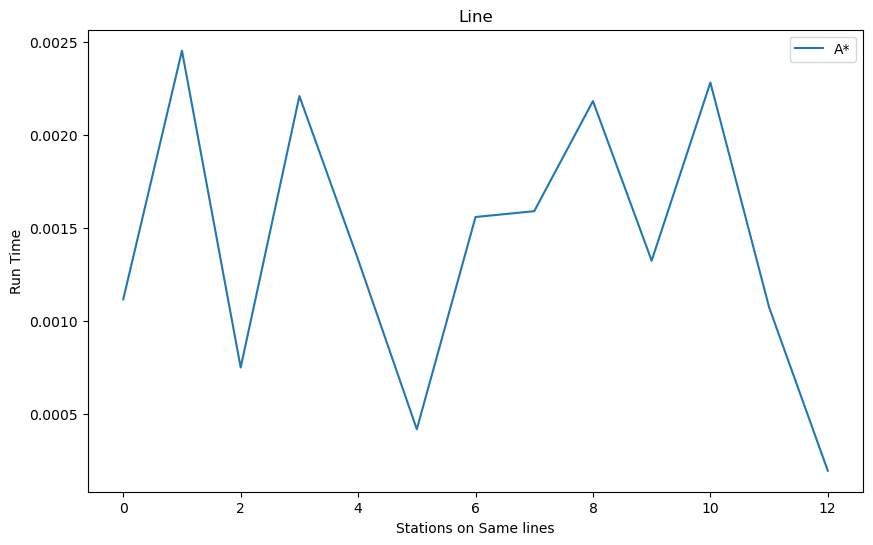

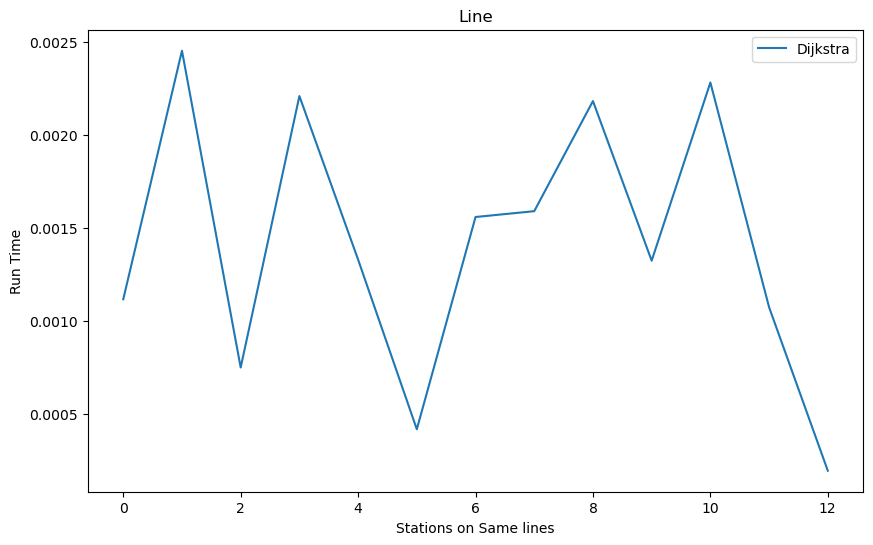

In [60]:
#find stations on same line

g = london_graph.graph

same_lines = {}

for connection in connections:
    l = connection['line']
    
    s1 = int(connection['station1'])
    s2 = int(connection['station2'])

    #let each line be a key, leading to the set of stations on that line
    if l not in list(same_lines.keys()):
        same_lines[l] = set()

    same_lines[l].add(s1)
    same_lines[l].add(s2)

print(same_lines)

#run A star and Dijksra on both

#record runtimes of but and plot

x_space = np.linspace(0.5,1,15)

run_times1 = []
run_times2 = []

for l1 in list(same_lines.keys()):

    st = sorted(list(same_lines[l1]))

    times = []
    times2 = []

    for s1 in st:
        for s2 in st:

            if s1 != s2:
                short_path = A_Star(london_graph, s1, s2, h_1)
                short_path2 = Dijkstra2(london_graph)

                #time a star
                start = timeit.default_timer()
                short_path.shortest_path()[1]
                stop = timeit.default_timer()

                times.append(stop-start)

                #time dijkstra
                start = timeit.default_timer()
                short_path2.find_shortest_paths(s1)[1]
                stop = timeit.default_timer()

                times2.append(stop-start)



    avg = sum(times)/len(times)
    avg2 = sum(times2)/len(times2)

    run_times1.append(avg)
    run_times2.append(avg)



plt.figure(figsize=(10, 6))
plt.plot(run_times1, label='A*')
plt.xlabel('Stations on Same lines')
plt.ylabel('Run Time')
plt.title('Line')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(run_times2, label='Dijkstra')
plt.xlabel('Stations on Same lines')
plt.ylabel('Run Time')
plt.title('Line')
plt.legend()
plt.show()

